In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# random seed for replicability
tf.random.set_seed(42)
np.random.seed(42)

preprocessed_dir = 'preprocessed_images'
os.makedirs(preprocessed_dir, exist_ok=True)

# DATA PREPARATION

df = pd.read_csv('train.csv')

df['image_id'] = df['image_id'].astype(str) + '.jpg'

# labels to binary (0 or 1)
label_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']
for col in label_cols:
    df[col] = (df[col] > 0).astype(int)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# DATA GENERATION 

train_dir = 'images'  # original images folder
target_size = (256, 256)
batch_size = 32

def save_preprocessed_images(generator, subset_name):
    generator.reset()
    os.makedirs(os.path.join(preprocessed_dir, subset_name), exist_ok=True)
    
    for i in range(len(generator)):
        x_batch, y_batch = next(generator)
        for j in range(len(x_batch)):
            img_id = generator.filenames[generator.index_array[i * generator.batch_size + j]]
            img_array = x_batch[j]
            img_path = os.path.join(preprocessed_dir, subset_name, img_id)
            tf.keras.preprocessing.image.save_img(img_path, img_array)

# augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda x: x 
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: x 
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='image_id',
    y_col=label_cols,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='image_id',
    y_col=label_cols,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)

save_preprocessed_images(train_generator, 'train')
save_preprocessed_images(val_generator, 'val')

train_generator.reset()
val_generator.reset()

# MODEL ARCHITECTURE 

def create_model(input_shape=(256, 256, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='sigmoid')  # sigmoid for multi-label classification
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model

model = create_model()
model.summary()

# TRAINING
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks
)

2025-05-14 23:59:04.115866: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 23:59:04.116396: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 23:59:04.118958: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 23:59:04.125132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747281544.134889  128932 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747281544.13

Found 1456 validated image filenames.
Found 365 validated image filenames.


/home/saioku/Downloads/646_Final_Project/tf-env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1747281564.350373  128932 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747281564.351809  128932 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,081,092 (99.49 MB)

 Trainable params: 26,081,092 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

/home/saioku/Downloads/646_Final_Project/tf-env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.3483 - auc: 0.6261 - loss: 0.5699

46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 811ms/step - accuracy: 0.3483 - auc: 0.6264 - loss: 0.5693 - val_accuracy: 0.3288 - val_auc: 0.6495 - val_loss: 0.5230
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 800ms/step - accuracy: 0.3204 - auc: 0.6513 - loss: 0.5216 - val_accuracy: 0.3288 - val_auc: 0.6768 - val_loss: 0.5261
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.3698 - auc: 0.6915 - loss: 0.5120

46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 794ms/step - accuracy: 0.3699 - auc: 0.6915 - loss: 0.5120 - val_accuracy: 0.3699 - val_auc: 0.6874 - val_loss: 0.5135
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.3965 - auc: 0.7050 - loss: 0.5060

46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 813ms/step - accuracy: 0.3970 - auc: 0.7052 - loss: 0.5059 - val_accuracy: 0.4767 - val_auc: 0.7343 - val_loss: 0.5004
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 806ms/step - accuracy: 0.4296 - auc: 0.7099 - loss: 0.5068 - val_accuracy: 0.4438 - val_auc: 0.7394 - val_loss: 0.5067
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.4662 - auc: 0.7443 - loss: 0.4918

46/46 ━━━━━━━━━━━━━━━━━━━━ 39s 838ms/step - accuracy: 0.4662 - auc: 0.7445 - loss: 0.4916 - val_accuracy: 0.5918 - val_auc: 0.8023 - val_loss: 0.4465
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.5689 - auc: 0.8059 - loss: 0.4516

46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 799ms/step - accuracy: 0.5693 - auc: 0.8063 - loss: 0.4512 - val_accuracy: 0.5699 - val_auc: 0.8016 - val_loss: 0.4401
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.6784 - auc: 0.8772 - loss: 0.3662

46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 807ms/step - accuracy: 0.6780 - auc: 0.8771 - loss: 0.3665 - val_accuracy: 0.6301 - val_auc: 0.8478 - val_loss: 0.4108
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.6854 - auc: 0.8897 - loss: 0.3577

46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 805ms/step - accuracy: 0.6860 - auc: 0.8901 - loss: 0.3572 - val_accuracy: 0.7370 - val_auc: 0.9114 - val_loss: 0.3157
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.7563 - auc: 0.9211 - loss: 0.3200

46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 803ms/step - accuracy: 0.7563 - auc: 0.9212 - loss: 0.3198 - val_accuracy: 0.7616 - val_auc: 0.9329 - val_loss: 0.2825
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 797ms/step - accuracy: 0.7526 - auc: 0.9299 - loss: 0.2868 - val_accuracy: 0.7233 - val_auc: 0.9174 - val_loss: 0.3051
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 805ms/step - accuracy: 0.7518 - auc: 0.9228 - loss: 0.3103 - val_accuracy: 0.6658 - val_auc: 0.8915 - val_loss: 0.4030
Epoch 13/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 780ms/step - accuracy: 0.7627 - auc: 0.9345 - loss: 0.2799 - val_accuracy: 0.7288 - val_auc: 0.9320 - val_loss: 0.2863
Epoch 14/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.7661 - auc: 0.9407 - loss: 0.2681

46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 808ms/step - accuracy: 0.7662 - auc: 0.9407 - loss: 0.2682 - val_accuracy: 0.8110 - val_auc: 0.9463 - val_loss: 0.2533
Epoch 15/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 793ms/step - accuracy: 0.8045 - auc: 0.9509 - loss: 0.2457 - val_accuracy: 0.7425 - val_auc: 0.9286 - val_loss: 0.2952
Epoch 16/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.8051 - auc: 0.9509 - loss: 0.2414

46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 820ms/step - accuracy: 0.8047 - auc: 0.9507 - loss: 0.2419 - val_accuracy: 0.8082 - val_auc: 0.9525 - val_loss: 0.2389
Epoch 17/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.7862 - auc: 0.9393 - loss: 0.2687

46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 799ms/step - accuracy: 0.7861 - auc: 0.9392 - loss: 0.2688 - val_accuracy: 0.7945 - val_auc: 0.9546 - val_loss: 0.2366
Epoch 18/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 827ms/step - accuracy: 0.7977 - auc: 0.9548 - loss: 0.2333 - val_accuracy: 0.8055 - val_auc: 0.9517 - val_loss: 0.2428
Epoch 19/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 800ms/step - accuracy: 0.8375 - auc: 0.9607 - loss: 0.2166 - val_accuracy: 0.8110 - val_auc: 0.9514 - val_loss: 0.2402
Epoch 20/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.8519 - auc: 0.9641 - loss: 0.2110

46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 796ms/step - accuracy: 0.8515 - auc: 0.9640 - loss: 0.2112 - val_accuracy: 0.8767 - val_auc: 0.9773 - val_loss: 0.1643
Epoch 21/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 795ms/step - accuracy: 0.8334 - auc: 0.9535 - loss: 0.2337 - val_accuracy: 0.8384 - val_auc: 0.9690 - val_loss: 0.2024
Epoch 22/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 799ms/step - accuracy: 0.8693 - auc: 0.9687 - loss: 0.1867 - val_accuracy: 0.8247 - val_auc: 0.9548 - val_loss: 0.2382
Epoch 23/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 796ms/step - accuracy: 0.8774 - auc: 0.9701 - loss: 0.1794 - val_accuracy: 0.8575 - val_auc: 0.9732 - val_loss: 0.1771
Epoch 24/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.8831 - auc: 0.9752 - loss: 0.1655

46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 806ms/step - accuracy: 0.8831 - auc: 0.9751 - loss: 0.1656 - val_accuracy: 0.8822 - val_auc: 0.9834 - val_loss: 0.1399
Epoch 25/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 803ms/step - accuracy: 0.8693 - auc: 0.9738 - loss: 0.1714 - val_accuracy: 0.8630 - val_auc: 0.9717 - val_loss: 0.1761
Epoch 26/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 795ms/step - accuracy: 0.8967 - auc: 0.9793 - loss: 0.1554 - val_accuracy: 0.8959 - val_auc: 0.9817 - val_loss: 0.1407
Epoch 27/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 815ms/step - accuracy: 0.8888 - auc: 0.9771 - loss: 0.1603 - val_accuracy: 0.8767 - val_auc: 0.9788 - val_loss: 0.1544
Epoch 28/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 821ms/step - accuracy: 0.8911 - auc: 0.9806 - loss: 0.1486 - val_accuracy: 0.8466 - val_auc: 0.9652 - val_loss: 0.1949
Epoch 29/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 792ms/step - accuracy: 0.9081 - auc: 0.9823 - loss: 0.1387 - val_accuracy: 0.8658 - val_auc: 0.9737 - val_loss: 0.1720


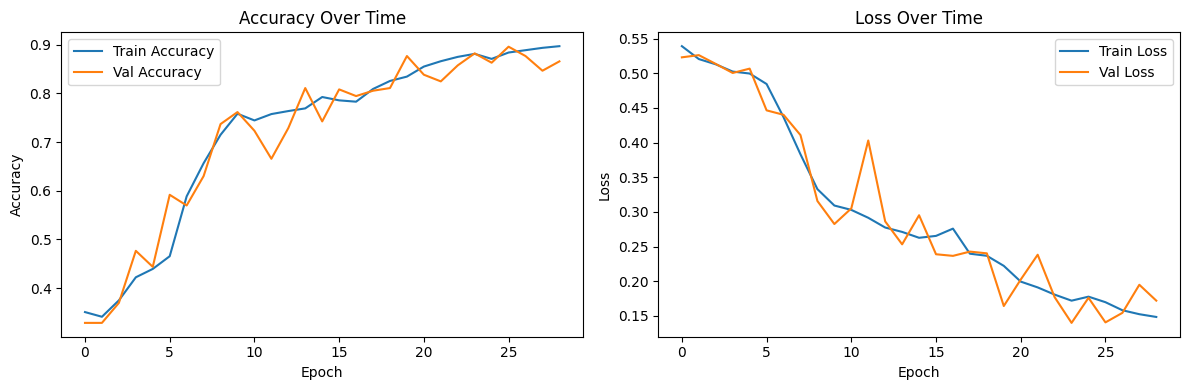

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.8966 - auc: 0.9881 - loss: 0.1188
Validation Loss: 0.1399
Validation Accuracy: 0.8822
Validation AUC: 0.9834


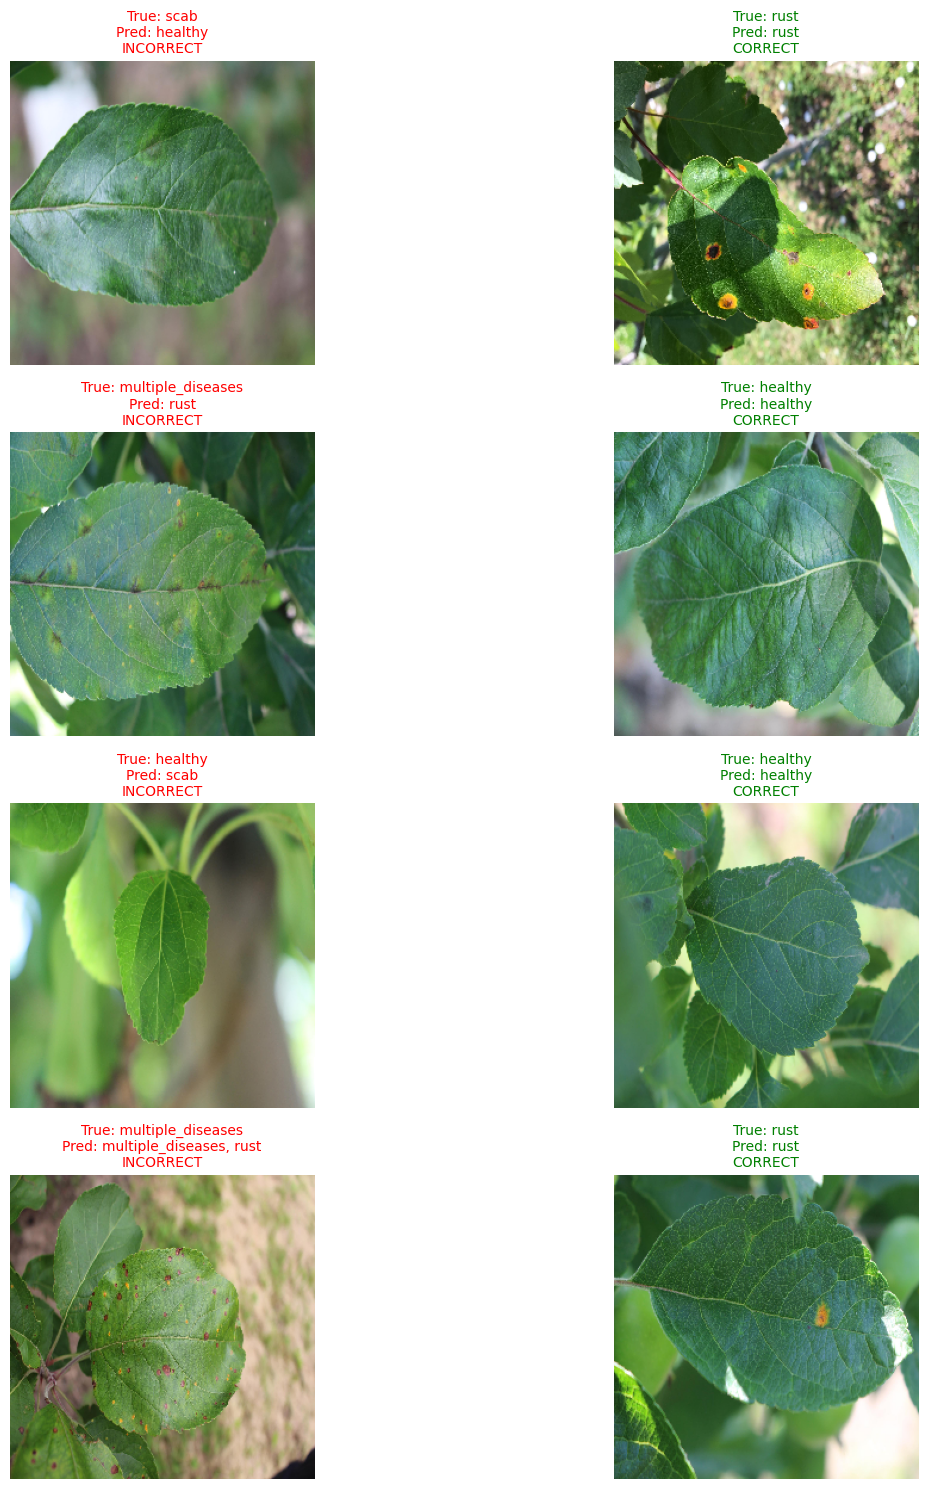

In [ ]:
#EVALUATION

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

results = model.evaluate(val_generator)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")
print(f"Validation AUC: {results[2]:.4f}")

def visualize_predictions(generator, model, num_samples=8, max_batches=5):
    generator.reset()
    class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']
    
    correct_samples = []
    incorrect_samples = []
    
    batches_checked = 0
    
    while (len(correct_samples) < num_samples//2 or len(incorrect_samples) < num_samples//2) and batches_checked < max_batches:
        x_batch, y_true = next(generator)
        y_pred = model.predict(x_batch, verbose=0)
        
        for i in range(len(x_batch)):
            correct = np.array_equal((y_true[i] > 0.5), (y_pred[i] > 0.5))
            true_labels = [class_names[j] for j in range(4) if y_true[i][j] > 0.5]
            pred_labels = [class_names[j] for j in range(4) if y_pred[i][j] > 0.5]
            
            sample_data = {
                'image': x_batch[i],
                'true_labels': true_labels,
                'pred_labels': pred_labels,
                'correct': correct
            }
            
            if correct and len(correct_samples) < num_samples//2:
                correct_samples.append(sample_data)
            elif not correct and len(incorrect_samples) < num_samples//2:
                incorrect_samples.append(sample_data)
            
            if len(correct_samples) >= num_samples//2 and len(incorrect_samples) >= num_samples//2:
                break
        
        batches_checked += 1
    
    # combine samples (alternating correct and incorrect)
    all_samples = []
    for i in range(max(len(correct_samples), len(incorrect_samples))):
        if i < len(incorrect_samples):
            all_samples.append(incorrect_samples[i])
        if i < len(correct_samples):
            all_samples.append(correct_samples[i])
    
    plt.figure(figsize=(15, 15))
    for i, sample in enumerate(all_samples[:num_samples]):
        plt.subplot((num_samples+1)//2, 2, i+1)
        plt.imshow(sample['image'])
        
        title = f"True: {', '.join(sample['true_labels']) if sample['true_labels'] else 'none'}\n"
        title += f"Pred: {', '.join(sample['pred_labels']) if sample['pred_labels'] else 'none'}\n"
        title += "CORRECT" if sample['correct'] else "INCORRECT"
        
        plt.title(title, fontsize=10, color='green' if sample['correct'] else 'red')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(val_generator, model, num_samples=8)